## Task:Build a 24-hour prediction model in Python 3 to provide:
### 1. Demand for the next 24 hours;
### 2. Confidence bounds with each prediction.
### 3. Capture anomalies in the time series.
#### Report on the training and validation regimes you’ve used, and any other relevant work.
#### Maximum 2 pages (including plots).

### Imports

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.vector_ar.var_model import VAR
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from pmdarima.arima import auto_arima
import math
from sklearn.metrics import mean_squared_error
%matplotlib inline

## Exploring data

In [2]:
#read data to data frame
data = pd.read_csv('data.csv')
data.describe()

,is_holiday,is_festival,is_regional_game_sport_1,is_regional_game_sport_2,temperature,previous_3_hour_max_precip,Total_Demand lag 0
count,102333.000000,102333.000000,102333.000000,102333.000000,102234.000000,102277.000000,87403.000000
mean,0.031896,0.029082,0.015049,0.014541,5.438484,0.066962,477.362838
std,0.175724,0.168036,0.121748,0.119706,10.619909,0.683921,167.144286
min,0.000000,0.000000,0.000000,0.000000,-29.300000,-99.000000,-3794.500185
25%,0.000000,0.000000,0.000000,0.000000,-0.900000,0.000000,377.590608
50%,0.000000,0.000000,0.000000,0.000000,5.900000,0.000000,508.842211
75%,0.000000,0.000000,0.000000,0.000000,12.800000,0.030500,578.978096
max,1.000000,1.000000,1.000000,1.000000,32.900000,6.941800,4829.563921


In [3]:
data.dtypes

DATE_TIME                      object
is_holiday                      int64
is_festival                     int64
is_regional_game_sport_1        int64
is_regional_game_sport_2        int64
temperature                   float64
previous_3_hour_max_precip    float64
Total_Demand lag 0            float64
dtype: object

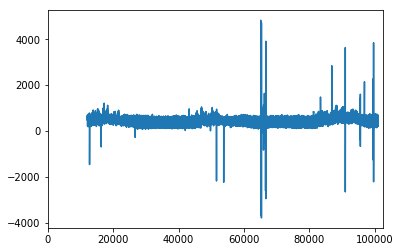

In [4]:
data['Total_Demand lag 0'].plot()

### Data Pre processing, missing values

In [5]:
def dataPreProcessing(data):
    #removing rows with no demand values 
    data = data[data['Total_Demand lag 0'].isnull() == False]
    #fill missing data with adjecent values
    data = data.fillna(method='ffill')
    #removing data for the day with incomplete data
    data = data.iloc[65:,]
    return data
    

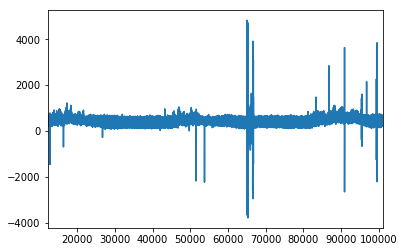

In [6]:
data = dataPreProcessing(data)
data['Total_Demand lag 0'].plot()

It looks like we have many spikes in the data indicating outliers or Anamolies. Lets examine for outliers using z - score method

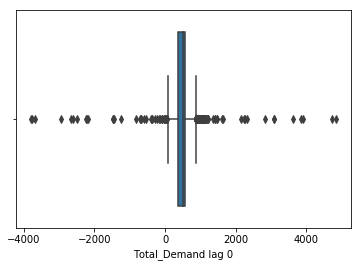

In [7]:
sns.boxplot(x=data['Total_Demand lag 0'])

## Capture anomalies in the time series and treat them

There are many outliers present in the data. Lets find them and treat them 

In [8]:
def outlierTreatment(data):
    #standardazing the demand values to check against the z-score values 
    scaler = StandardScaler()
    scaler.fit(data[['Total_Demand lag 0']])
    z_df = pd.DataFrame(scaler.transform(data[['Total_Demand lag 0']]))
    # replacing z scores with values greater that 3 and less than -3
    z_df[abs(z_df) > 3] = None
    z_df[abs(z_df) < -3] = None
    new = pd.DataFrame(scaler.inverse_transform(z_df))
    new.columns = ['Demand']
    data.reset_index(drop=True, inplace=True)
    new.reset_index(drop=True, inplace=True)
    final = pd.concat([data, new], axis = 1)
    final.drop(['Total_Demand lag 0'], axis = 1, inplace = True)
    # fill outliers values with neighbouring values
    final['Demand'] = final['Demand'].fillna(method='ffill')
    # creating date_time as index to the data frame
    final['DATE_TIME'] = pd.to_datetime(final.DATE_TIME , format = '%Y-%m-%d %H:%M')
    df = final.drop(['DATE_TIME'], axis=1)
    df.index = final.DATE_TIME
    df = df[['Demand']]
    return df

In [9]:
data = outlierTreatment(data)
data.head()

,Demand
DATE_TIME,
2015-05-07 00:00:00,271.987641
2015-05-07 00:15:00,237.828319
2015-05-07 00:30:00,202.813658
2015-05-07 00:45:00,233.749718
2015-05-07 01:00:00,248.291042


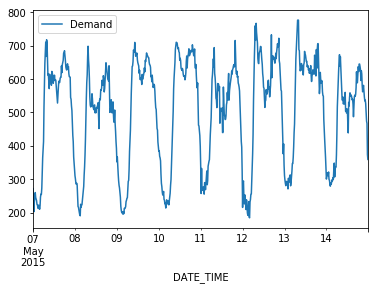

In [10]:
# Inspecting the daily trends for 8 days
data.head(96*8).plot()

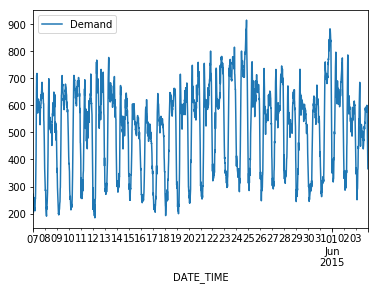

In [11]:
# Inspecting the weekly trends for 4 weeks
data.head(96*7*4).plot()

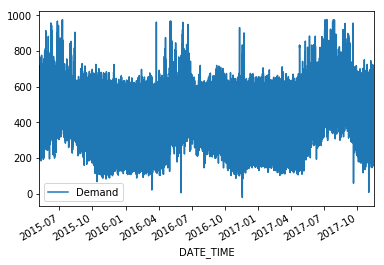

In [12]:
#plotting entire series with outlier treated data
data.plot()

## Check for Stationarity of series using augmented Dickey–Fuller test (ADF)

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [13]:
result = adfuller(data['Demand'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -24.530541
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


Running the example prints the test statistic value of -24. The more negative this statistic, the more likely we are to reject the null hypothesis.
So We conclude that data is stationary.

## ARIMA model

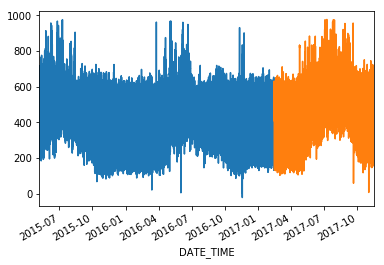

In [14]:
train = data[:int(0.7*(len(data)))]
valid = data[int(0.7*(len(data))):]

#plotting the data
train['Demand'].plot()
valid['Demand'].plot()

## Model Validation with rmse

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=569703.864, BIC=569757.989, Fit time=42.391 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=578269.954, BIC=578287.996, Fit time=2.238 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=577692.354, BIC=577719.416, Fit time=2.779 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=577876.260, BIC=577903.323, Fit time=13.844 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=570165.124, BIC=570210.228, Fit time=29.346 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=569705.816, BIC=569768.962, Fit time=57.097 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=570748.483, BIC=570793.587, Fit time=53.904 seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=569705.844, BIC=569768.990, Fit time=61.136 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: 

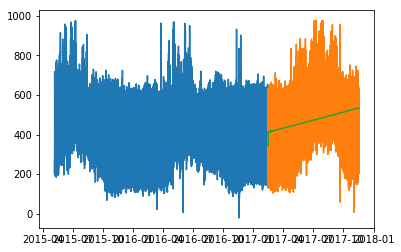

In [18]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(train, label='Train')
plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [19]:
print('rmse value is : ', math.sqrt(mean_squared_error(forecast, valid)))

rmse value is :  165.3737492967882


In [20]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(data)

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=569703.864, BIC=569757.989, Fit time=44.679 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=578269.954, BIC=578287.996, Fit time=3.624 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=577692.354, BIC=577719.416, Fit time=4.946 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=577876.260, BIC=577903.323, Fit time=14.667 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=570165.124, BIC=570210.228, Fit time=29.260 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=569705.816, BIC=569768.962, Fit time=56.919 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=570748.483, BIC=570793.587, Fit time=47.596 seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=569705.844, BIC=569768.990, Fit time=44.947 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: 

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(5, 1, 5),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

## Forecast for next 24 hours water demand with 15 minutes interval

In [21]:
forecast = model.predict(n_periods=96, return_conf_int=True)
forecast = pd.DataFrame(forecast)
fcast = []
for i, arr in enumerate(forecast.iloc[1,:]):
    fcast.append((forecast.iloc[0,i], arr[0], arr[1]))
fcast = pd.DataFrame(fcast)
fcast.columns = ['point estimate', '95% CI LB', '95% CI UB']

## forecast with 95% Confidence Interval

In [22]:
fcast.head()

,point estimate,95% CI LB,95% CI UB
0,542.710223,492.153214,593.267233
1,535.671324,464.307030,607.035618
2,529.566091,436.542304,622.589878
3,527.510024,411.044815,643.975233
4,528.140813,387.146437,669.135190


## Plotting the forecasts

In [23]:
data.reset_index(drop=True, inplace=True)
fcast.reset_index(drop=True, inplace=True)
graph = pd.concat([data[['Demand']],fcast], axis = 0)

/home/shreesha/anaconda3/envs/DSDJ/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


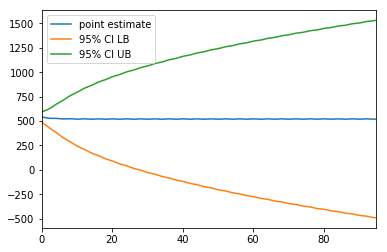

In [24]:
fcast.plot()

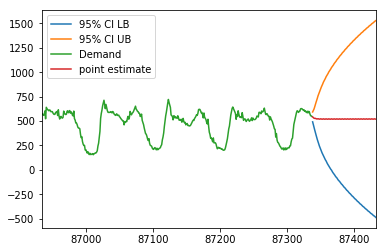

In [25]:
graph.reset_index(drop=True, inplace=True)
graph.tail(500).plot()

## Saving the forecast to a csv file

In [27]:
fcast.to_csv('fcastARIMA.csv',index=False)